## Create and test ion channel model

In [1]:
from channels.icat_markov_testing import (protocols,
                                          conditions,
                                          observations,
                                          simulations,
                                          times,
                                          summary_statistics)

INFO:myokit:Loading Myokit version 1.28.3


In [2]:
def simulate_model(**pars):
    """Wrapper function around simulations."""
    data = []
    for sim, time in zip(simulations, times):
        for p, v in pars.items():
            try:
                sim.set_constant(p, v)
            except:
                raise RuntimeWarning('Could not set value of {}'.format(p))
                return None
        sim.reset()
        try:
            data.append(sim.run(time, log=['environment.time','icat.i_CaT','icat.g','icat.a','icat.r']))
        except:
            # Failed simulation
            del(data)
            return None
    return data

def pyabc_simulate(pars):
    res = simulate_model(**pars)
    return res

In [3]:
test = simulate_model()

In [4]:
ss = summary_statistics(test)

## Set limits and generate uniform initial priors

In [7]:
from pyabc import Distribution, RV
limits = {'icat.g_CaT': (0, 2.),
          'icat.E_Ca_offset': (-100., 100.), # accounts for reversal potential difference from Nernst 
          'icat.p_1': (-50, 50),
          'icat.p_2': (0, 1.),
          'icat.p_3': (-50, 50),
          'icat.p_4': (0, 1.),
          'icat.p_5': (-50, 50),
          'icat.p_6': (0, 1.),
          'icat.p_7': (-50, 50),
          'icat.p_8': (0, 1.)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

## Run ABC calibration

In [8]:
import os, tempfile
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "hl-1_icat_markov_development.db"))
print(db_path)

sqlite:////scratch/cph211/tmp/hl-1_icat_markov_development.db


In [9]:
# Let's log all the sh!t
import logging
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)
cv_logger = logging.getLogger('CV Estimation')
cv_logger.setLevel(logging.DEBUG)

In [10]:
from pyabc.populationstrategy import AdaptivePopulationSize, ConstantPopulationSize
from ionchannelABC import theoretical_population_size
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 1024 particles


In [11]:
from pyabc import ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor

abc = ABCSMC(models=pyabc_simulate,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.01),
             population_size=ConstantPopulationSize(10000),
             #population_size=AdaptivePopulationSize(
             #    start_nr_particles=10000,
             #    mean_cv=0.4,
             #    max_population_size=30000,
             #    min_population_size=pop_size),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=20),
             sampler=MulticoreEvalParallelSampler(n_procs=12),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 2.042662507755895, '1': 2.042662507755895, '2': 1.3175173175025499, '3': 1.5057340771457712, '4': 0.8107798876938791, '5': 0.34000446903291687, '6': 0.19518775074111877, '7': 0.16468966468781915, '8': 0.16468966468781915, '9': 0.16468966468781915, '10': 0.16215597753877592, '11': 0.17000223451645843, '12': 0.1882167596432214, '13': 0.1756689756670071, '14': 0.1988705384909512, '15': 0.2291334465221833, '16': 0.2509556795242961, '17': 0.2702599625646261, '18': 0.34000446903291687, '19': 0.3634530531041516, '20': 0.45826689304436596, '21': 0.5019113590485913, '22': 0.4582668930443666, '23': 1.219705208958084, '24': 1.3213473097046027, '25': 1.132583408318225, '26': 2.3490618839192794, '27': 2.3490618839192794, '28': 0.8345351429713199, '29': 0.5285389238818384, '30': 0.4285450734177068, '31': 0.46635787401338613, '32': 0.5662917041591125, '33': 0.7928083858227557, '34': 1.0570778477636744, '35': 1.5856167716455234, '36': 1.5856167716455114, '37': 2.34

In [12]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [13]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=14, start_time=2019-06-07 14:16:38.013231, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0.1, max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:20
DEBUG:ABC:now submitting population 0
/scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov_testing.py:158: RuntimeWarning: divide by zero encountered in double_scalars
  ss[str(cnt)] = max2/max1
DEBUG:ABC:population 0 done


# Results analysis

In [5]:
from pyabc import History

In [6]:
history = History('sqlite:////scratch/cph211/tmp/hl-1_icat_markov_development.db')
history.all_runs()

[<ABCSMC(id=1, start_time=2019-05-30 18:07:40.408441, end_time=None)>,
 <ABCSMC(id=2, start_time=2019-05-30 18:10:25.594125, end_time=None)>,
 <ABCSMC(id=3, start_time=2019-06-01 19:02:44.112039, end_time=None)>,
 <ABCSMC(id=4, start_time=2019-06-01 19:35:13.827705, end_time=2019-06-02 22:22:42.886944)>,
 <ABCSMC(id=5, start_time=2019-06-03 08:31:42.926297, end_time=2019-06-04 22:26:08.322448)>,
 <ABCSMC(id=6, start_time=2019-06-05 09:11:20.225936, end_time=2019-06-05 23:52:50.008280)>,
 <ABCSMC(id=7, start_time=2019-06-06 10:10:13.326372, end_time=None)>,
 <ABCSMC(id=8, start_time=2019-06-06 10:14:19.400187, end_time=None)>,
 <ABCSMC(id=9, start_time=2019-06-06 10:23:14.962316, end_time=None)>,
 <ABCSMC(id=10, start_time=2019-06-06 18:10:34.152940, end_time=None)>,
 <ABCSMC(id=11, start_time=2019-06-06 18:19:05.365111, end_time=None)>,
 <ABCSMC(id=12, start_time=2019-06-06 18:19:12.042146, end_time=None)>,
 <ABCSMC(id=13, start_time=2019-06-06 20:29:05.273889, end_time=2019-06-07 10:0

In [7]:
history.id = 13

In [8]:
df, w = history.get_distribution(m=0)

In [24]:
df.describe()

name,icat.E_Ca_offset,icat.g_CaT,icat.p_1,icat.p_2,icat.p_3,icat.p_4,icat.p_5,icat.p_6,icat.p_7,icat.p_8
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,18.054906,0.022185,5.176425,0.285022,-26.959223,0.415301,7.775432,0.354424,-35.847533,0.706369
std,49.399216,0.011512,6.537848,0.137400,11.005732,0.164079,5.687286,0.208086,10.039782,0.162093
min,-99.971916,0.000032,-4.720796,0.000081,-49.988680,0.000574,-5.127608,0.000021,-49.997818,0.017422
25%,-16.948494,0.013739,0.699342,0.183227,-35.302828,0.295672,3.764484,0.182674,-43.101610,0.603456
50%,23.624744,0.021308,3.332912,0.262874,-26.574027,0.418327,7.517389,0.336207,-37.831742,0.723435
75%,57.365803,0.029367,7.459763,0.366322,-18.469773,0.535402,11.134003,0.514533,-30.811796,0.828720
max,99.995931,0.081404,33.582638,0.781638,7.776331,0.903577,36.018426,0.834580,24.273383,0.999833


/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '
/scratch/cph211/miniconda3/envs/ionchannelABC/lib/python3.7/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make ax

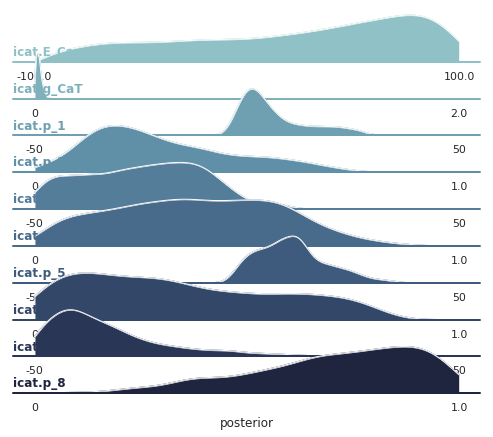

In [25]:
from ionchannelABC import plot_parameters_kde
g = plot_parameters_kde(df, w, limits, aspect=12,height=0.6)

# Samples for quantitative analysis

In [8]:
# Generate parameter samples
n_samples = 100
df, w = history.get_distribution(m=0)
th_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')

In [9]:
plotting_obs = observations.copy()

In [10]:
plotting_obs.rename({'exp_id': 'exp', 'variance': 'errs'}, axis=1, inplace=True)

> /scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov_testing.py(152)summary_statistics()
-> pulse1 = d.trim_right(300)['icat.i_CaT']
(Pdb) n
> /scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov_testing.py(153)summary_statistics()
-> endtime = d['environment.time'][-1]
(Pdb) import matplotlib.pyplot as plt
(Pdb) plt.plot(pulse1)
(Pdb) plt.show()


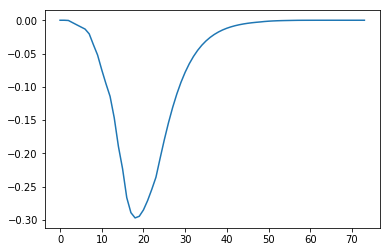

(Pdb) n
> /scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov_testing.py(154)summary_statistics()
-> pulse2 = d.trim_left(endtime-300, adjust=True)['icat.i_CaT']
(Pdb) n
> /scratch/cph211/ion-channel-ABC/docs/examples/channels/icat_markov_testing.py(156)summary_statistics()
-> max1 = np.max(np.abs(pulse1))
(Pdb) plt.plot(pulse2)
(Pdb) plt.show()


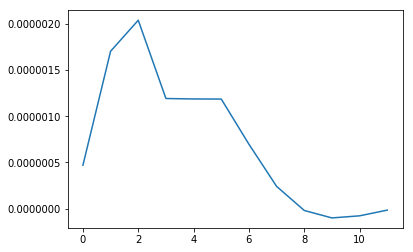

(Pdb) q


BdbQuit: 

In [11]:
# Generate sim results samples
import pandas as pd
samples = pd.DataFrame({})
for i, th in enumerate(th_samples):
    results = summary_statistics(pyabc_simulate(pars=th))
    output = pd.DataFrame({'x': plotting_obs.x, 'y': list(results.values()),
                           'exp': plotting_obs.exp})
    #output = model.sample(pars=th, n_x=50)
    output['sample'] = i
    output['distribution'] = 'post'
    samples = samples.append(output, ignore_index=True)

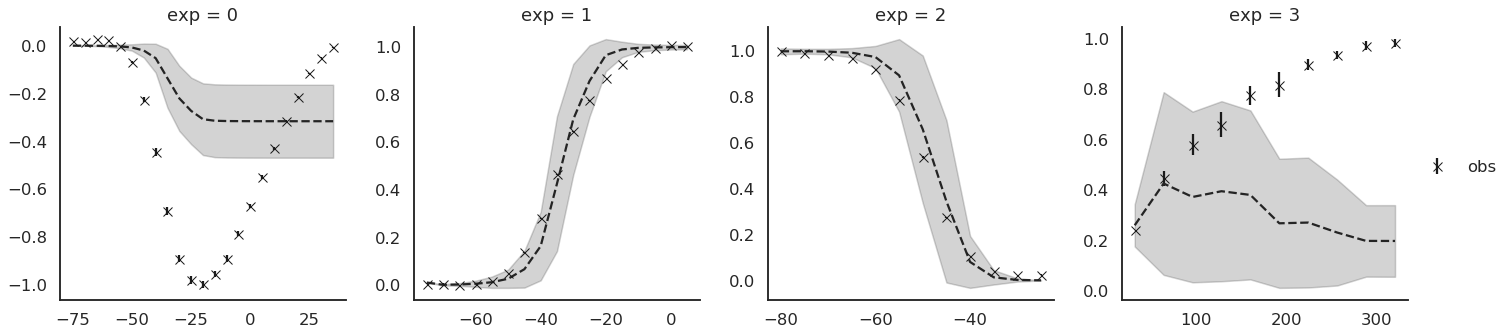

In [30]:
from ionchannelABC import plot_sim_results
import seaborn as sns
sns.set_context('talk')
g = plot_sim_results(samples, obs=plotting_obs)

# Set axis labels
#xlabels = ["voltage, mV", "voltage, mV", "voltage, mV", "time, ms", "time, ms","voltage, mV"]
#ylabels = ["current density, pA/pF", "activation", "inactivation", "recovery", "normalised current","current density, pA/pF"]
#for ax, xl in zip(g.axes.flatten(), xlabels):
#    ax.set_xlabel(xl)
#for ax, yl in zip(g.axes.flatten(), ylabels):
#    ax.set_ylabel(yl)

In [31]:
#g.savefig('results/icat-generic/icat_sim_results.pdf')

In [32]:
def plot_sim_results_all(samples: pd.DataFrame):
    with sns.color_palette("gray"):
        grid = sns.relplot(x='x', y='y',
                           col='exp',
                           units='sample',
                           kind='line',
                           data=samples,
                           estimator=None, lw=0.5,
                           alpha=0.5,
                           #estimator=np.median,
                           facet_kws={'sharex': 'col',
                                      'sharey': 'col'})
    return grid

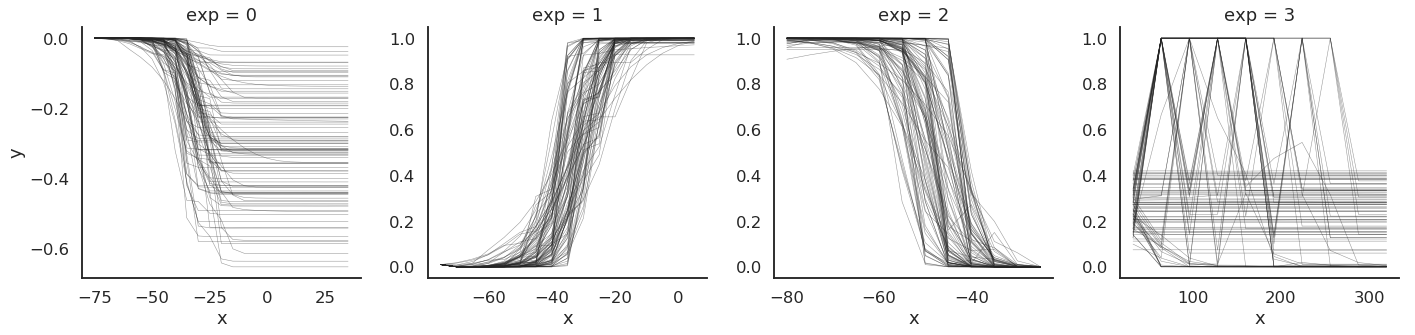

In [33]:
grid2 = plot_sim_results_all(samples)

In [73]:
grid2.savefig('results/icat-generic/icat_sim_results_all.pdf')

In [74]:
# Mean current density
print(np.mean(samples[samples.exp==0].groupby('sample').min()['y']))
# Std current density
print(np.std(samples[samples.exp==0].groupby('sample').min()['y']))

-12.28849522978163
0.11884277718478846


In [75]:
import scipy.stats as st
peak_current = samples[samples['exp']==0].groupby('sample').min()['y'].tolist()
rv = st.rv_discrete(values=(peak_current, [1/len(peak_current),]*len(peak_current)))

In [76]:
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -12.305081453952692
95% CI: (-12.500217629136861, -12.042063814242947)


In [77]:
# Voltage of peak current density
idxs = samples[samples.exp==0].groupby('sample').idxmin()['y']
print("mean: {}".format(np.mean(samples.iloc[idxs]['x'])))
print("STD: {}".format(np.std(samples.iloc[idxs]['x'])))

mean: -21.885714285714286
STD: 1.0634278539232422


In [78]:
voltage_peak = samples.iloc[idxs]['x'].tolist()
rv = st.rv_discrete(values=(voltage_peak, [1/len(voltage_peak),]*len(voltage_peak)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -21.122448979591837
95% CI: (-23.367346938775512, -21.122448979591837)


In [79]:
# Half activation potential
# Fit of activation to Boltzmann equation
from scipy.optimize import curve_fit
grouped = samples[samples['exp']==1].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1/(1+np.exp((Vhalf-V)/K))
    guess = (-30, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y)
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [80]:
print(np.mean(output))
print(np.std(output))

0   -34.577896
1     5.249907
dtype: float64
0    0.235155
1    0.153233
dtype: float64


In [81]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -34.58363058983856
95% CI: (-35.0824309590915, -34.05139450727638)


In [82]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 5.224802366288811
95% CI: (4.983346458403857, 5.580422234103727)


In [83]:
# Half activation potential
grouped = samples[samples['exp']==2].groupby('sample')
def fit_boltzmann(group):
    def boltzmann(V, Vhalf, K):
        return 1-1/(1+np.exp((Vhalf-V)/K))
    guess = (-100, 10)
    popt, _ = curve_fit(boltzmann, group.x, group.y,
                        bounds=([-100, 1], [0, 30]))
    return popt
output = grouped.apply(fit_boltzmann).apply(pd.Series)

In [84]:
print(np.mean(output))
print(np.std(output))

0   -51.099701
1     2.015624
dtype: float64
0    0.324099
1    0.124022
dtype: float64


In [85]:
Vhalf = output[0].tolist()
rv = st.rv_discrete(values=(Vhalf, [1/len(Vhalf),]*len(Vhalf)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: -51.139541001530084
95% CI: (-51.91973135023897, -50.483201273719196)


In [86]:
slope = output[1].tolist()
rv = st.rv_discrete(values=(slope, [1/len(slope),]*len(slope)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 1.9931521591606465
95% CI: (1.7945341598364295, 2.2778268479073294)


In [87]:
# Recovery time constant
grouped = samples[samples.exp==3].groupby('sample')
def fit_single_exp(group):
    def single_exp(t, I_max, tau):
        return I_max*(1-np.exp(-t/tau))
    guess = (1, 50)
    popt, _ = curve_fit(single_exp, group.x, group.y, guess)
    return popt[1]
output = grouped.apply(fit_single_exp)

In [88]:
print(np.mean(output))
print(np.std(output))

134.15783981052365
6.8765524851314765


In [89]:
tau = output.tolist()
rv = st.rv_discrete(values=(tau, [1/len(tau),]*len(tau)))
print("median: {}".format(rv.median()))
print("95% CI: {}".format(rv.interval(0.95)))

median: 134.09052469517178
95% CI: (124.17078543531227, 147.7723663936914)
